# Despiking Data
## Import Necessary Modules

In [1]:
import os.path

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

Import the data from CSV file. `pandas.read_csv` is more versatile than e.g. `numpy.genfromtxt`. The source CSV file contains the [semi-major axis](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes) for all objects launched with a Falcon 9 on 2020-09-03 from Launch Complex 39A (LC-39A) at Kennedy Space Center in Florida ([launch recording on Youtube](https://www.youtube.com/watch?v=_j4xR7LMCGY)). The CSV file is structured in four columns:

* `norad`: NORAD catalogue ID
* `name`: object name
* `epoch`: epoch in UTC for the semi-major axis
* `semi-major axis`: semi-major axis in [km]

The CSV file is imported to a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object with the following columns computed from the data in the CSV file:

* `norad`: NORAD catalogue ID, as above
* `name`: object name, as above
* `time`: difference between the epoch and the launch time ([pd.timedelta64](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html) object in nanoseconds)
* `alt`: altitude of the orbit given as the difference between the semi-major axis and the mean Earth radius in [km]. Almost all orbits in lower LEO are circular with very low eccentricity. Therefore, `alt` can be considered as altitude.

In [98]:
# datafile: ./data/2020-06.dat
datafile = os.path.join(os.path.curdir, 'data', '2020-062.dat')
launch_date = "2020-09-03 12:46:14"

RE = 6378.137 # Earth radius in km

data_all = pd.read_csv(datafile, delimiter=',', quotechar='"', names=["norad","name","time","alt"])


data_all['deltatime'] = pd.to_datetime(data_all['time']) - pd.to_datetime(launch_date)

data_all['alt'] = data_all['alt'] - RE

See what we got:

In [99]:
data_all
type(data_all['norad'])

pandas.core.series.Series

Filter data for only one object (given by specific NORAD catalogue ID)

In [100]:
this_norad = 46325
#norad = 46440
#norad = 47023
obj = data_all.query('norad == @this_norad')
obj

,norad,name,time,alt,deltatime
0,46325,STARLINK-1734,2020-09-07 21:07:38,224.134,4 days 08:21:24
1,46325,STARLINK-1734,2020-09-08 07:30:10,225.970,4 days 18:43:56
2,46325,STARLINK-1734,2020-09-08 10:28:22,228.638,4 days 21:42:08
3,46325,STARLINK-1734,2020-09-08 13:26:31,228.914,5 days 00:40:17
4,46325,STARLINK-1734,2020-09-08 20:00:01,228.982,5 days 07:13:47
...,...,...,...,...,...
542,46325,STARLINK-1734,2021-08-22 10:54:06,547.214,352 days 22:07:52
543,46325,STARLINK-1734,2021-08-23 15:33:48,547.204,354 days 02:47:34
544,46325,STARLINK-1734,2021-08-24 07:29:12,547.195,354 days 18:42:58
545,46325,STARLINK-1734,2021-08-25 15:19:58,547.181,356 days 02:33:44


The data is not evenly sampled (the time difference between consecutive rows is not constant. To analyze the sampling period, compute the time differences `dt` of the rows in the dataframe `obj` as an additional column using the [pandas dataframe diff method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html):

In [101]:
#obj['dt'] = obj['deltatime'].diff(periods=1)

dt = obj['deltatime'].diff(periods=1)
obj.insert(len(obj.columns), 'dt', dt)
obj

,norad,name,time,alt,deltatime,dt
0,46325,STARLINK-1734,2020-09-07 21:07:38,224.134,4 days 08:21:24,NaT
1,46325,STARLINK-1734,2020-09-08 07:30:10,225.970,4 days 18:43:56,0 days 10:22:32
2,46325,STARLINK-1734,2020-09-08 10:28:22,228.638,4 days 21:42:08,0 days 02:58:12
3,46325,STARLINK-1734,2020-09-08 13:26:31,228.914,5 days 00:40:17,0 days 02:58:09
4,46325,STARLINK-1734,2020-09-08 20:00:01,228.982,5 days 07:13:47,0 days 06:33:30
...,...,...,...,...,...,...
542,46325,STARLINK-1734,2021-08-22 10:54:06,547.214,352 days 22:07:52,0 days 23:53:05
543,46325,STARLINK-1734,2021-08-23 15:33:48,547.204,354 days 02:47:34,1 days 04:39:42
544,46325,STARLINK-1734,2021-08-24 07:29:12,547.195,354 days 18:42:58,0 days 15:55:24
545,46325,STARLINK-1734,2021-08-25 15:19:58,547.181,356 days 02:33:44,1 days 07:50:46


In [102]:
# For testing: Dropping column dt
#obj.drop(columns=['dt'], inplace=True)
#obj = obj.drop(columns=['dt'])

Plot a histrogram for the sampling period

<IPython.core.display.Javascript object>


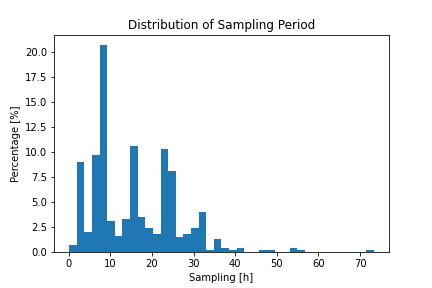

Text(0, 0.5, 'Percentage [%]')

In [103]:
dt_hist = plt.figure()
ax = dt_hist.add_subplot()

# Exclude the first row for plotting, because there dt == nat (not a time)
counts, bins = np.histogram(obj['dt'][1:] / timedelta(hours=1), bins=40)
percent = [i/sum(counts)*100 for i in counts]

ax.hist(bins[:-1], bins, weights=percent)
ax.set_title('Distribution of Sampling Period')
ax.set_xlabel('Sampling [h]')
ax.set_ylabel('Percentage [%]')

In the above histogram plot we see local maxima for ~ 90 minutes (the orbital period of the satellites), 9, 16 and 24 hours. The "period" of 72 hours corresponds to the time needed for the first orbital determination after launch.

Now, plot the semimajor axis over time.
`obj['time']` is of type `pd.timedelta64` and is the time difference in nanoseconds. For plotting, the value is transferred to days (after launch).

<IPython.core.display.Javascript object>


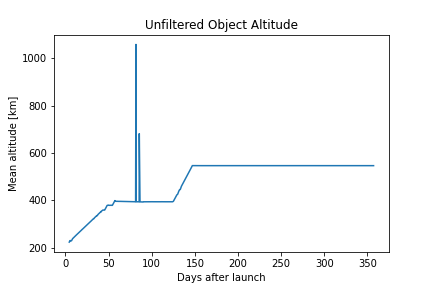

Text(0, 0.5, 'Mean altitude [km]')

In [104]:
alt = plt.figure()
ax = alt.add_subplot()
ax.plot(obj['deltatime'] / timedelta(days=1), obj['alt'], "-")
ax.set_title("Unfiltered Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

In the above plot we see spikes at around 80 days after launch. It is very unlikely that the spacecraft actually made this kind of orbit manoeuvre. The Starlink satellites have only a low thrust electric propulsion system.

Roughly, the mean altitude for the spacecraft was raised in the first ~ 56 days after launch followed by a time period with constant altitude. After ~ 125 days the altitude was again raised over the next ~ 10 days to the final operational altitude of slightly above 550 km.

## Filtering using Threshold for the 1st Derivative
Calculate the absolute value of the first derivative `abs_deriv` of alt in m/s and add this data as a new column to the dataframe `obj`. The derivative is calculated using [numpy gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html).

`obj['deltatime'] / timedelta(seconds=1)` converts from `pandas.timedelta64` to seconds.

In [105]:
abs_deriv = abs(np.gradient(obj['alt'] * 1E3, obj['deltatime'] / timedelta(seconds=1), edge_order = 1))
obj = obj.assign(abs_deriv = abs_deriv)

Plot the absolute value of the derivative.

<IPython.core.display.Javascript object>


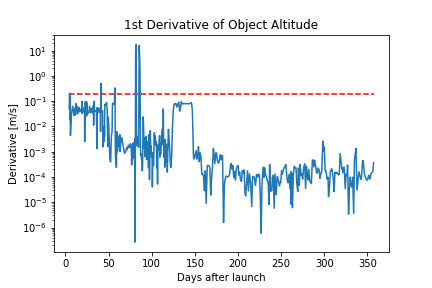

In [108]:
deriv = plt.figure()
ax = deriv.add_subplot()
ax.plot(obj['deltatime'] / timedelta(days=1), obj['abs_deriv'], "-")
ax.set_yscale('log')
ax.set_title("1st Derivative of Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Derivative [m/s]")

deriv_threshold = 0.2
tmin = obj['deltatime'].min() / timedelta(days=1)
tmax = obj['deltatime'].max() / timedelta(days=1)
ax.hlines(deriv_threshold, tmin, tmax, colors = 'r', linestyles = 'dashed')

The above plot can be interpreted as the change of the mean orbital altitude with time in units of m/s. We can rediscover the two time periods where the mean altitude was raised corresponding to relatively high values for the first derivative (~ 0.04 ... 0.09 m/s). Also the spikes can be easily identified by values for the derivative orders of magnitude higher that the hightest typical values.

Filter the altitude data using `deriv_threshold`. `obj['alt_derivfilt']` is a copy of `obj['alt_derivfilt']` with values set to nan (not a number) of `abs_deriv` exceeds `deriv_threshold`.

In [139]:
# Create new column
obj = obj.assign(alt_derivfilt = obj['alt'])
# Set outliers to nan
obj.loc[(obj.abs_deriv > deriv_threshold), 'alt_derivfilt'] = np.nan

# Linear interpolation on column "alt_derivfilt" and substitute NaN
obj["alt_derivfilt"].interpolate(method='linear', limit_direction='forward', inplace=True)



0      224.134
1      226.386
2      228.638
3      228.914
4      228.982
        ...   
542    547.214
543    547.204
544    547.195
545    547.181
546    547.213
Name: alt_derivfilt, Length: 547, dtype: float64

In [150]:
#ts_df = obj[["time", "alt_derivfilt"]]
ts_df["alt_km"] = obj.loc[:, ('alt_derivfilt')]
ts_df
#ts_df.index = pd.DatetimeIndex(obj["time"])


#aaaa = ts_df.resample('1H').interpolate()
#np.dft(aaaa)

# Naechste Schritte hier>
# np.dft auf Hoehe oder will man doch 2d FFT?
# https://numpy.org/doc/stable/reference/routines.fft.html
# Hohe Frequenz Abschneiden
# np.idft 
# Fertig und plotten.


NameError: name 'ts_df' is not defined

<IPython.core.display.Javascript object>


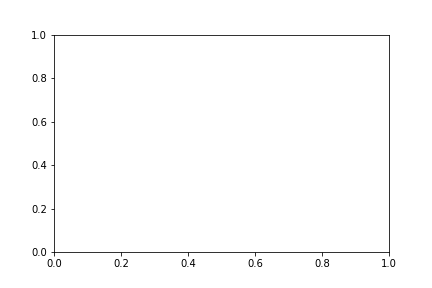

ValueError: only leading negative signs are allowed

In [134]:
alt_filt1 = plt.figure()
ax = alt_filt1.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_derivfilt'], linestyle='-', marker='')
ax.set_title("Filtered using Threshold for 1st Derivative")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

## Filtering using Moving Median

Define function for custom [moving median filter](https://www.mathworks.com/help/matlab/ref/movmedian.html) `movmedian`. The argument `boxhw` defines the width of the box for the filter. The width is `2 * boxhw + 1`, which ensures, that the box width is always uneven (at least while the box is not touching the boundaries).

In [ ]:
def movmedian(data, boxhw):
    data_filtered = []

    for i in range(0,len(data)):
        # Lower boundary
        lb = i - boxhw if i >= boxhw else 0
        # Upper boundary
        ub = i + boxhw if i + boxhw < len(data) else len(data)-1
        # Calculate median from array slice (sliding window)
        data_filtered.append(np.median(data[lb:ub+1]))
        #print(i, lb, ub, data[lb:ub+1], np.median(data[lb:ub+1]))

    return data_filtered

Apply filter to `obj['alt']` and create new column `obj['alt_mmfilt']` in dataframe.

In [ ]:
box_half_width = 5
obj = obj.assign(alt_mmfilt = movmedian(obj['alt'], box_half_width))

In [ ]:
alt_filt2 = plt.figure()
ax = alt_filt2.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_mmfilt'], "-")
title = (
    "Filtered using Moving Median ("
    + str(box_half_width)
    + "-1-"
    + str(box_half_width)
    + ")"
)
ax.set_title(title)
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")